# Why Displays Cannot Show Pure Emission Lines
> So how can the observed colour from spectra be displayed? An exploration of the CIE 1931 color space and how that relates to sRGB. Python code included.

- toc: true 
- badges: true
- comments: true
- categories: []
- image: images/2021-01-25-displaying_spectra_files/CIE1931xy_srgb.svg
- hide: true
- search_exclude: true
- permalink: /colour_of_spectra/

In [45]:
#hide 
from coloured_spectra.coloured_spectra import * # wrote this library for this blog post
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Introduction

Okay, you got yourself a spectrometer and you now have a spectra. As a sensible person, you did *not* stare into the end of the fiber optic cable to see what colour that spectra represents. (And seriously, do not do this with your remaining eye either!) So you decide to simulate what that colour is from the spectra you obtained but as it turns, this task is *not* trivial. This was the story of how this blog post came to be. 

In this blog post, we will discuss human vision and the colour spaces that are necessary to represent spectra in the "right" colour - in particular the CIE 1931 XYZ colour space. In doing so, we will discover that there are colours that we can see but are not possible to display on screens and how to work around this. Lastly, as a demonstration, we will see how spectra can be coloured. 



# The Human Vision

The ordinary human eye has three types of cone cells that are sensitive to different spectral ranges under bright conditions. (When it is dark, rod cells dominate and they give us monochromatic vision.) They are the short "S", middle "M", and long "L" cones and their sensitivity is shown in Figure 1. Together, this forms the LMS colour space and is good for simulating various human eye visual receptions but is otherwise not very useful for computer displays. We will get to why later but the fundamental reason lies in the overlap between the L, M, and S sensitivities. 

![](https://upload.wikimedia.org/wikipedia/commons/0/04/Cone-fundamentals-with-srgb-spectrum.svg "Figure 1: Normalised spectral sensitivity of human cone cells. Also, we are more sensitive to green light.")

## Displays and the sRGB Colour Space

According to [this website](https://techterms.com/definition/srgb#:~:text=sRGB%20is%20a%20color%20space,%2C%20green%2C%20and%20blue%20values), the definition of colours that can be displayed on screens fall under the Standard RGB (sRGB) standard. So in order to represent a colour to show on our screens, we must produce an sRGB representation from a spectra. As it turns out, this conversion between from spectra to sRGB cannot be done directly and we must turn to a standard reference that defines other colour spaces called the CIE XYZ colour space. 

## The CIE XYZ Colour Space

The Commission Internationale de l'éclairage (CIE) 1931 XYZ colour space defines all colour sensations an average human can experience. 

> Note: **The CIE Standard Observer**: The distribution of cones depends on the field of view so in initial experiments, this was set to be within 2° arc of the fovea. Other angles were used later including 10$^\circ$. 

### Matching Functions

The matching functions were obtained by the standard observers and is shown below (produced from an analytic approximation). Overall, these are similar to the LMS plot in Figure 1 with a notable difference - the bumb in X($\lambda$) around 450 nm. I haven't found conclusive evidence why that is but after experimenting in code, this bump is needed to get conversions to *indigo and violet* for wavelengths close to 400 nm. Without this bump, the displayed colour would just be blue and if you've seen a rainbow, the colours of the rainbow do not go from red to green to blue but includes a shade of purple too. 






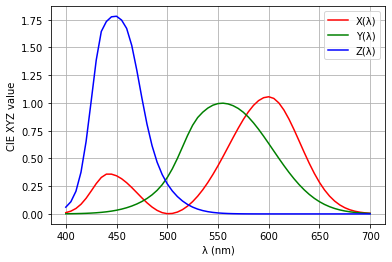

In [46]:
plot_cie_xyz_matching_functions()

Here is a rainbow for good measure.

![](https://media.nationalgeographic.org/assets/photos/000/284/28417.jpg "Figure 2: A rainbow that shows indigo and violet colours")


In Figure 3, the boundary of the coloured shark fin represent the colour of each pure wavelength. By definition, the sRGB colour space is a subset of the CIE XYZ. Any chromaticity that lies outside the sRGB triangle will have some R, G, or B values that are *negative* and cannot be displayed. Let's look at why this is the case using an example.

![](..images/2021-01-25-displaying_spectra_files/CIE1931xy_srgb.svg "Figure 3: sRGB is a subset of CIE XYZ.")

The white point is marked as D65. What is the reasoning behind this naming?

#### D65 and the CIE Standard Illuminant

[D65](https://en.wikipedia.org/wiki/Illuminant_D65) is known as the CIE standard illuminant and is roughly equivalent to daylight at midday Europe. The 65 refers to a colour temperature of 6500 K (actually 6504 K after physical constants were revised). There are other standard illuminants defined by different colour temperatures. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/SPD_D65.png/512px-SPD_D65.png "Figure 4: D65 spectral power distribution.")

#### How to display a pure green spectral line?
Let's use the CIE XYZ space for the sake of this argument. The same reasoning can be applied to the LMS colour space.
In our example, we assume that [green on the display is emitted at 532 nm](https://www.rp-photonics.com/rgb_sources.html) (will depend on your display!). Then this pure spectral line will have components in X, Y, and Z but most of the contribution is towards Y. 





In [47]:
wavelength2xyz(532) # X, Y, and Z contributions at 520 nm

array([0.18198845, 0.88928536, 0.03742325])

If we treated these values as the same as sRGB and that the possible sRGB values lie between 0 (min) and 1 (max), then what colour will be displayed? 

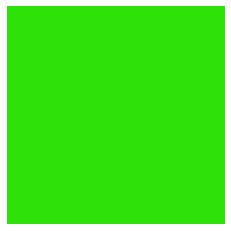

In [48]:
plot_colour([0.18198845, 0.88928536, 0.03742325])

Then the colour will less green than expected, whitened by adding blue and red, and shifted a little more red when it should just display only green components! Can you tell the difference bewteen the green above and below?

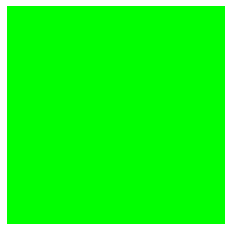

In [49]:
plot_colour([0,1.,0])

The same can be said for any other pure wavelength. 

### How to deal with negative sRGB values

Here, we will see two ways we can deal with negative sRGB values. They are: clamping all negatives to zero, and whitening.
In whitening, we add to all channels until all numbers are non-negative then rescale the result such that the original max sRGB value is unchanged. 
The following plots will show you what the difference is.

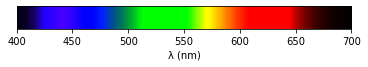

In [50]:
plot_wavelength_colours("CLAMP")

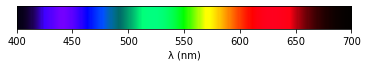

In [51]:
plot_wavelength_colours("WHITEN")

## Colour of a Blackbody 

The Sun can be appoximated as a blackbody with temperature 5778 K. Let's see what colour this spectra corresponds to.


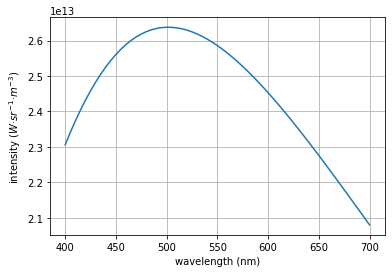

In [52]:
bb = Blackbody(5778)
bb.plot()

In [53]:

def show_blackbody_colour(T_K):
    bb = Blackbody(T_K,np.linspace(380,750))
    
    sRGB = spectra2sRGB(bb.λ_nm,bb.B_λT)

    # Due to normalisation choices, the brightness can change depending on the spectra
    # show the same hue at max brightness
    HSV = cv2.cvtColor(np.reshape(sRGB,(1,1,3)), cv2.COLOR_RGB2HSV_FULL)
    HSV[0,0,2] = 255
    RGB = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB_FULL)

    plot_colour(RGB)

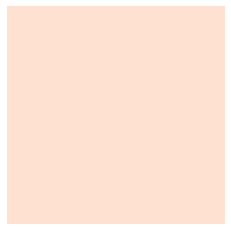

In [54]:
show_blackbody_colour(5778)

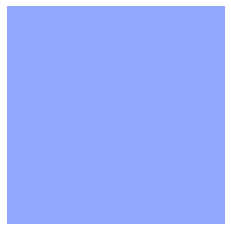

In [55]:
show_blackbody_colour(11000) # what about the star Rigel?

# Displaying spectra

Let's artifically create the spectra for HgAr and then use `coloured_spectra` to show the emission lines in its colour. 
We can't see UV and NIR so those emission lines will be coloured white. The colour palette for each wavelength we will be using is shown below.


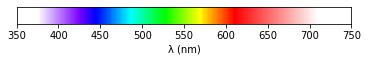

In [56]:
plot_hsv_LUT_spectrum()

This is a simulated HgAr spectra.

Text(0.5, 0, 'wavelength (nm)')

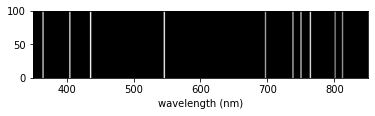

In [57]:
lines_nm = [254,436,546,764,405,365,750,738,697,812,912,801] # approx sorted by emission strength
img = np.zeros((100,1000))
wavelengths = np.linspace(350,850,1000)

strength = 1.
for line in lines_nm: 
    indx = np.sum(wavelengths<line)
    if indx > 0 and indx < 1000:
        img[:,indx-2:indx+2] = strength
        strength -= 0.05

plt.imshow(img,cmap="gray",extent=[np.min(wavelengths),np.max(wavelengths),0,np.shape(img)[0]])
plt.xlabel("wavelength (nm)")


100%|██████████| 100/100 [00:01<00:00, 50.28it/s]


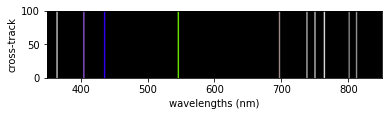

In [58]:
colour_hyperspectral_line(wavelengths,img)

# Conclusion
In this blog post, we learned that displays cannot show all the colours we can see. We saw how the CIE 1931 XYZ colour space can be used to generate suitable sRGB values to display including ways to mitigate negative sRGB values. As a cool demo, we ended on colouring in the HgAr emission spectra.